In [10]:
import torch
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Get Knowing the Data

In [3]:
MNISTtrain = pd.read_csv("mnist_train_small.csv", header=None)
MNISTtest = pd.read_csv("mnist_test.csv", header=None)

In [4]:
MNISTtrain.shape

(20000, 785)

In [4]:
import math
math.sqrt(784)

28.0

In [5]:
sample1 = MNISTtrain.iloc[0]
sample1.shape

(785,)

In [6]:
label1 = sample1[0]

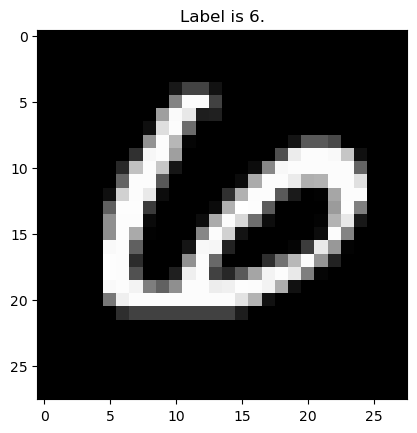

In [7]:
pixels = sample1[1:]
pixels = np.array(pixels, dtype='uint8')
pixels = pixels.reshape((28, 28))

# Plot
plt.title(f"Label is {label1}.")
plt.imshow(pixels, cmap='gray')
plt.show()

# Create An Iterable Dataset

In [8]:
class MNISTDataSet(torch.utils.data.Dataset):
    def __init__(self, df, transforms=None):
        self.X = df.iloc[:,1:]
        self.y = df.iloc[:,0]
        self.transforms = transforms

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        image = self.X.iloc[idx, :]
        # image: ndarray
        image = (np.array(image).astype(np.float32).reshape(28, 28, 1))
        sample = {'image': image, 'label':(self.y[idx])}

        if self.transforms:
            sample['image'] = self.transforms(sample['image'])

        return sample

In [11]:
transform = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,))])
# Converts a torch.*Tensor of shape C x H x W
# or a numpy ndarray of shape H x W x C to a PIL Image
# while adjusting the value range depending on the mode.

In [12]:
# 数据转化
trainset = MNISTDataSet(MNISTtrain, transforms=transform)

In [13]:
batch_size = 64

In [16]:
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [17]:
for i_batch, sample_batched in enumerate(trainloader):
    if i_batch == 0:
      print(i_batch, sample_batched['image'].size(),
            sample_batched['label'].size())
      break

0 torch.Size([64, 1, 28, 28]) torch.Size([64])


# CNN

`torch.nn` has the layers we need.

`torch.nn.functional` has the activation functions.

The APIs can be found using the link at the bottom.

In [18]:
import torch.nn as nn
import torch.nn.functional as F

__LeNet5__

In [19]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5) # initial in_channel must be specified
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
# torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1,
#                 groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
# out(Ni, Coutj) = bias(Coutj) + sumk(weight(Coutj, k) * input(Ni, k))
# torch.nn.MaxPool2d(kernel_size, stride=None, padding=0,
#                    dilation=1, return_indices=False, ceil_mode=False)
# https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d

In [21]:
net = Net()

Loss and optimizer: MNIST is the 10-class classification dataset. 

We use `CrossEntropyLoss` and `SGD`. 

Note that the `SGD` in `torch` is just gradient descent. 

We have already provided the "mini-batch" part.

In [22]:
import torch.optim as optim

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [24]:
for param in net.parameters():
    print(type(param), param.size())

<class 'torch.nn.parameter.Parameter'> torch.Size([6, 1, 5, 5])
<class 'torch.nn.parameter.Parameter'> torch.Size([6])
<class 'torch.nn.parameter.Parameter'> torch.Size([16, 6, 5, 5])
<class 'torch.nn.parameter.Parameter'> torch.Size([16])
<class 'torch.nn.parameter.Parameter'> torch.Size([120, 256])
<class 'torch.nn.parameter.Parameter'> torch.Size([120])
<class 'torch.nn.parameter.Parameter'> torch.Size([84, 120])
<class 'torch.nn.parameter.Parameter'> torch.Size([84])
<class 'torch.nn.parameter.Parameter'> torch.Size([10, 84])
<class 'torch.nn.parameter.Parameter'> torch.Size([10])


# Train the Model

In [25]:
def trainBySGD(epochSize):
    for epoch in range(epochSize):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data['image'], data['label']

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 100 == 99:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0

    print('Finished Training')
# torch.nn.CrossEntropyLoss(weight=None, size_average=None, ignore_index=-100, 
#                           reduce=None, reduction='mean', label_smoothing=0.0)

In [26]:
trainBySGD(5)

[1,   100] loss: 0.073
[1,   200] loss: 0.016
[1,   300] loss: 0.012
[2,   100] loss: 0.008
[2,   200] loss: 0.008
[2,   300] loss: 0.008
[3,   100] loss: 0.006
[3,   200] loss: 0.005
[3,   300] loss: 0.006
[4,   100] loss: 0.004
[4,   200] loss: 0.004
[4,   300] loss: 0.004
[5,   100] loss: 0.003
[5,   200] loss: 0.004
[5,   300] loss: 0.004
Finished Training


# Evaluation

In [27]:
testset = MNISTDataSet(MNISTtest, transforms=transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True)
net.eval()

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [28]:
predictions = torch.LongTensor()
truevalues = torch.LongTensor()
loss = 0

In [29]:
for idx, eval_batched in enumerate(testloader):
    images = eval_batched['image']
    label_true = eval_batched['label']
    preds = net(images)
    predictions = torch.cat((predictions, preds.argmax(dim=1)), dim=0)
    truevalues = torch.cat((truevalues, label_true), dim=0)
    loss = criterion(preds, label_true)
    if idx <= 10:
      print(preds.argmax(dim=1)[0:4], label_true[0:4])
loss

tensor([4, 8, 7, 1]) tensor([4, 8, 7, 1])
tensor([7, 9, 7, 9]) tensor([7, 9, 5, 9])
tensor([7, 7, 4, 7]) tensor([7, 7, 4, 7])
tensor([8, 5, 6, 0]) tensor([8, 5, 6, 0])
tensor([9, 1, 6, 0]) tensor([9, 1, 6, 0])
tensor([4, 2, 3, 6]) tensor([4, 2, 3, 6])
tensor([4, 5, 4, 6]) tensor([4, 5, 4, 6])
tensor([3, 2, 0, 5]) tensor([3, 2, 0, 5])
tensor([3, 3, 0, 7]) tensor([3, 3, 0, 7])
tensor([2, 9, 8, 9]) tensor([2, 9, 8, 9])
tensor([7, 3, 6, 0]) tensor([7, 3, 6, 0])


tensor(0.0053, grad_fn=<NllLossBackward0>)